!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install transformers
!pip install contractions
!pip install nltk
!pip install nlpaug

# 0. Importing dependencies & Configurations

In [1]:
import data
import models
import training
import augmenter_class

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import random
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler

import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig

import string
import contractions
import nltk
import nlpaug.augmenter.word as naw

C:\Users\Hussein\anaconda3\envs\KD_torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)

torch.cuda.empty_cache()
gc.collect()

device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch.autograd.set_detect_anomaly(True)
print(device)

cuda:0


# 1. Main Variables

In [3]:
DATA_PATH = "../stat940-winter-2024-datachallenge2/"
PRETRAINED_MODEL = "pig4431/20NG_raw_roBERTa_5E"
CHECKPOINT = None
INITIALIZATION = None

# 2. Data, Dataloader & Tokenizer

In [4]:
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)
augmenter = augmenter_class.Augmentation()

In [5]:
training_data = data.DatasetClass(os.path.join(DATA_PATH, "shuffled_train_1.csv"), 
                                  x_name = "deepSummary_text",
                                  is_labeled=True, 
                                  mode='train', 
                                  training_ratio=0.9, 
                                  x_transform=(lambda x: augmenter.text_augmentation(x)), 
                                  y_transform=(lambda y:y-1)
                                 )

testing_data = data.DatasetClass(os.path.join(DATA_PATH, "shuffled_train_1.csv"), 
                                  x_name = "deepSummary_text",
                                  is_labeled=True, 
                                  mode='test', 
                                  training_ratio=0.9, 
                                  x_transform=None, 
                                  y_transform=(lambda y:y-1)
                                 )

all_data = data.DatasetClass(os.path.join(DATA_PATH, "shuffled_train_1.csv"), 
                              x_name = "deepSummary_text",
                              is_labeled=True, 
                              mode='all', 
                              training_ratio=1, 
                              x_transform=None, 
                              y_transform=(lambda y:y-1)
                             )

In [6]:
train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)#, collate_fn= lambda x: collate_function(x, tokenizer))
test_dataloader = DataLoader(testing_data, batch_size=32, shuffle=True)#, collate_fn= lambda x: collate_function(x, tokenizer))
all_dataloader = DataLoader(all_data, batch_size=32, shuffle=True)#, collate_fn= lambda x: collate_function(x, tokenizer))

# 3. Model

## 3.1. Model Architecture

In [7]:
frozen_model = AutoModelForSequenceClassification.from_pretrained(PRETRAINED_MODEL)

C:\Users\Hussein\anaconda3\envs\KD_torch\lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [8]:
for param in frozen_model.parameters():
    param.requires_grad = False

In [9]:
frozen_model

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [10]:
for name, layer in frozen_model.classifier.named_children():
    setattr(frozen_model.classifier, name, nn.Identity())

In [11]:
frozen_model

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [12]:
model = models.ClassificationHead()

## 3.2. Model Initialization

In [13]:
if CHECKPOINT:
    print(f"Loading Stat_dict from checkpoint {CHECKPOINT}")
    model.to("cpu").load_state_dict(torch.load(CHECKPOINT)['model_state_dict'])
elif INITIALIZATION:
    for param in model.classifier.out_proj.parameters():
        if param.ndim >= 2:
            initialization(param)

In [14]:
model.to(device)

ClassificationHead(
  (layers): Sequential(
    (0): Linear(in_features=768, out_features=768, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=768, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=128, out_features=3, bias=True)
  )
)

# 4. Loss Function

In [15]:
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1, 1, 1], dtype=torch.float).to(device), label_smoothing=0.5)

# 5. Optimizer

In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)

# 6. Scheduler

In [17]:
#scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
scheduler = lr_scheduler.LinearLR(optimizer)

# 7. Training

In [18]:
train_1 = training.Training(name="data_aug", frozen_model=frozen_model, device=device)

In [19]:
train_1.complete_epoch(100, 
                       model, 
                       optimizer, 
                       scheduler, 
                       criterion, 
                       tokenizer, 
                       train_dataloader, 
                       test_dataloader
                      )

loss: 1.103004  [   32/ 5400]
loss: 1.082687  [ 3232/ 5400]
Epoch 1 has training_loss=1.070284366607666, training_accuracy=0.5007407407407407
Epoch 1 has testing_loss=1.0680712461471558, testing_accuracy=0.5433333333333333
learning rate at epoch 0 = 0.0003333333333333333
loss: 1.075861  [   32/ 5400]
loss: 1.065662  [ 3232/ 5400]
Epoch 2 has training_loss=1.0715235471725464, training_accuracy=0.5007407407407407
Epoch 2 has testing_loss=1.0700178146362305, testing_accuracy=0.49666666666666665
loss: 1.051117  [   32/ 5400]
loss: 1.064458  [ 3232/ 5400]
Epoch 3 has training_loss=1.0636029243469238, training_accuracy=0.5351851851851852
Epoch 3 has testing_loss=1.0685510635375977, testing_accuracy=0.5116666666666667
loss: 1.041397  [   32/ 5400]
loss: 1.066441  [ 3232/ 5400]
Epoch 4 has training_loss=1.0612154006958008, training_accuracy=0.5412962962962963
Epoch 4 has testing_loss=1.0690618753433228, testing_accuracy=0.5216666666666666
loss: 1.106811  [   32/ 5400]
loss: 1.090761  [ 3232/ 5

loss: 1.026390  [ 3232/ 5400]
Epoch 38 has training_loss=1.0361897945404053, training_accuracy=0.6111111111111112
Epoch 38 has testing_loss=1.0701552629470825, testing_accuracy=0.5383333333333333
loss: 1.048300  [   32/ 5400]
loss: 1.027822  [ 3232/ 5400]
Epoch 39 has training_loss=1.0411622524261475, training_accuracy=0.6033333333333334
Epoch 39 has testing_loss=1.0716912746429443, testing_accuracy=0.5333333333333333
loss: 1.063538  [   32/ 5400]
loss: 1.049530  [ 3232/ 5400]
Epoch 40 has training_loss=1.0483474731445312, training_accuracy=0.5731481481481482
Epoch 40 has testing_loss=1.0729875564575195, testing_accuracy=0.505
loss: 1.051796  [   32/ 5400]
loss: 1.035149  [ 3232/ 5400]
Epoch 41 has training_loss=1.0461883544921875, training_accuracy=0.592037037037037
Epoch 41 has testing_loss=1.075034499168396, testing_accuracy=0.5216666666666666
learning rate at epoch 40 = 0.00047311303205788136
loss: 1.059714  [   32/ 5400]
loss: 1.037635  [ 3232/ 5400]
Epoch 42 has training_loss=1.0

loss: 1.052383  [ 3232/ 5400]
Epoch 75 has training_loss=1.0234729051589966, training_accuracy=0.6551851851851852
Epoch 75 has testing_loss=1.075147271156311, testing_accuracy=0.5116666666666667
loss: 1.056968  [   32/ 5400]
loss: 1.024435  [ 3232/ 5400]
Epoch 76 has training_loss=1.020430088043213, training_accuracy=0.6653703703703704
Epoch 76 has testing_loss=1.0742238759994507, testing_accuracy=0.5183333333333333
loss: 1.031784  [   32/ 5400]
loss: 1.027767  [ 3232/ 5400]
Epoch 77 has training_loss=1.024389624595642, training_accuracy=0.6553703703703704
Epoch 77 has testing_loss=1.0727015733718872, testing_accuracy=0.5183333333333333
loss: 1.060518  [   32/ 5400]
loss: 1.041224  [ 3232/ 5400]
Epoch 78 has training_loss=1.0178035497665405, training_accuracy=0.6842592592592592
Epoch 78 has testing_loss=1.0746753215789795, testing_accuracy=0.5083333333333333
loss: 1.019892  [   32/ 5400]
loss: 1.012713  [ 3232/ 5400]
Epoch 79 has training_loss=1.0215829610824585, training_accuracy=0.66

{'train': [tensor(1.0703, device='cuda:0'),
  tensor(1.0715, device='cuda:0'),
  tensor(1.0636, device='cuda:0'),
  tensor(1.0612, device='cuda:0'),
  tensor(1.0585, device='cuda:0'),
  tensor(1.0596, device='cuda:0'),
  tensor(1.0588, device='cuda:0'),
  tensor(1.0570, device='cuda:0'),
  tensor(1.0594, device='cuda:0'),
  tensor(1.0606, device='cuda:0'),
  tensor(1.0577, device='cuda:0'),
  tensor(1.0530, device='cuda:0'),
  tensor(1.0587, device='cuda:0'),
  tensor(1.0529, device='cuda:0'),
  tensor(1.0520, device='cuda:0'),
  tensor(1.0535, device='cuda:0'),
  tensor(1.0479, device='cuda:0'),
  tensor(1.0499, device='cuda:0'),
  tensor(1.0504, device='cuda:0'),
  tensor(1.0516, device='cuda:0'),
  tensor(1.0481, device='cuda:0'),
  tensor(1.0520, device='cuda:0'),
  tensor(1.0479, device='cuda:0'),
  tensor(1.0473, device='cuda:0'),
  tensor(1.0515, device='cuda:0'),
  tensor(1.0444, device='cuda:0'),
  tensor(1.0451, device='cuda:0'),
  tensor(1.0496, device='cuda:0'),
  tensor(1.

In [20]:
train_1.inference_from_path(model, 
                            tokenizer,
                            os.path.join(DATA_PATH, "test.csv"), 
                            "data_aug_low_loss_model_checkpoint.pth", 
                            file_name="min_loss"
                           )

,ID,label
0,1,3
1,2,1
2,3,1
3,4,1
4,5,1
...,...,...
1796,1797,3
1797,1798,1
1798,1799,3
1799,1800,1


In [21]:
train_1.inference_from_path(model, 
                            tokenizer,
                            os.path.join(DATA_PATH, "test.csv"), 
                            "data_aug_high_acc_model_checkpoint.pth",
                            file_name="max_acc"
                           )

,ID,label
0,1,3
1,2,2
2,3,1
3,4,1
4,5,1
...,...,...
1796,1797,3
1797,1798,2
1798,1799,3
1799,1800,1


# 8. Analyzing the results

In [22]:
def calc_confusion_matrix(model, tokenizer, dataset, device="cpu", frozen_model=None):
    confusion_matrix = {}
    
    model.to(device)
    if frozen_model:
        frozen_model.to(device)
    
    model.eval()
    with torch.no_grad():
        for index in range(len(dataset)):
            x, y, z = dataset[index]
            x = tokenizer(x,
                      padding='longest', 
                      truncation=True,
                      return_tensors='pt'
                     )
            if x["input_ids"].ndim == 3:
                x = {key: value.squeeze(1).to(device) for key, value in x.items()}
            else:
                x = {key: value.to(device) for key, value in x.items()}
            
            if frozen_model:
                rep = frozen_model(**x).logits
                pred = model(rep)
            else:
                pred = model(**x).logits

            pred = pred.argmax(1).type(torch.int) + 1
            pair = (int(y.cpu().item())+1, int(pred.cpu().item()))
            confusion_matrix[pair] = confusion_matrix.get(pair, 0) + 1
    return confusion_matrix

In [23]:
model.to("cpu").load_state_dict(torch.load("data_aug_low_loss_model_checkpoint.pth")['model_state_dict'])

<All keys matched successfully>

In [24]:
test_confusion_matrix = calc_confusion_matrix(model, 
                                         tokenizer, 
                                         testing_data, 
                                         device, 
                                         frozen_model
                                        )

In [25]:
train_confusion_matrix = calc_confusion_matrix(model, 
                                         tokenizer, 
                                         training_data, 
                                         device, 
                                         frozen_model
                                        )

In [26]:
all_confusion_matrix = calc_confusion_matrix(model, 
                                         tokenizer, 
                                         all_data, 
                                         device, 
                                         frozen_model
                                        )

In [27]:
test_confusion_matrix

{(3, 1): 38,
 (3, 3): 160,
 (1, 3): 42,
 (1, 1): 129,
 (2, 1): 62,
 (2, 3): 84,
 (2, 2): 34,
 (1, 2): 28,
 (3, 2): 23}

In [28]:
train_confusion_matrix

{(1, 3): 226,
 (3, 3): 1238,
 (2, 1): 700,
 (2, 3): 670,
 (1, 2): 190,
 (1, 1): 1385,
 (3, 1): 326,
 (2, 2): 450,
 (3, 2): 215}

In [29]:
all_confusion_matrix

{(1, 3): 259,
 (3, 3): 1442,
 (2, 2): 425,
 (2, 3): 783,
 (1, 1): 1575,
 (3, 2): 192,
 (2, 1): 792,
 (3, 1): 366,
 (1, 2): 166}

# 9. Analyzing the quality of the generated distribution from the model

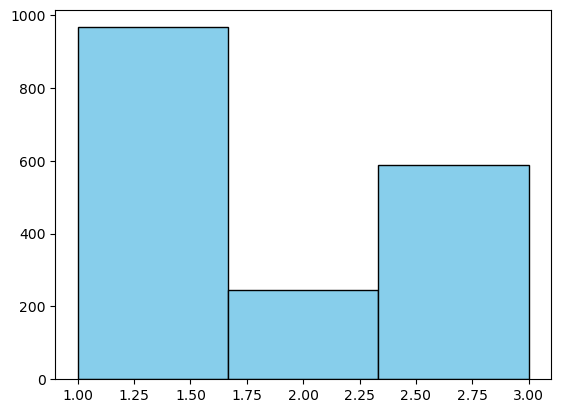

In [30]:
plt.hist(pd.read_csv("data_aug_predictions_min_loss.csv")["label"], bins=3, color='skyblue', edgecolor='black')
plt.show()

### The Model is biased toward 2 significantly

In [31]:
def write_inference_distribution_to_csv(model, tokenizer, dataloader, output_file, frozen_model=None, checkpoint=None, device="cpu"):
    
    if checkpoint is not None:
        model.to("cpu").load_state_dict(torch.load(checkpoint)['model_state_dict'])
        
    model.to(device)
    model.eval()
    # Initialize lists to store logits and predictions
    logits_list = []
    labels_list = []
    index_list = []
    pred_list = []
    with torch.no_grad():
        for x, y, z in dataloader:
            x = tokenizer(x,
                      padding='longest', 
                      truncation=True,
                      return_tensors='pt'
                     )
            x = {key: value.squeeze(1).to(device) for key, value in x.items()}
            if frozen_model:
                rep = frozen_model(**x).logits
                pred = model(rep)
            else:
                pred = model(**x).logits
            # Append logits to the list
            pred = F.softmax(pred, 1)
            pred_val = torch.argmax(pred, 1)
            y+=1
            
            logits_list.append(pred.cpu().numpy())
            labels_list.append(y.cpu().numpy())            
            index_list.append(z.cpu().numpy())
            pred_list.append(pred_val.cpu().numpy())

    # Concatenate logits from all batches
    all_logits = np.concatenate(logits_list)
    all_labels = np.concatenate(labels_list)
    all_index = np.concatenate(index_list)
    all_preds = np.concatenate(pred_list)

    all_logits = pd.DataFrame(all_logits, columns=["1", "2", "3"])
    all_labels = pd.DataFrame({
        "pred": all_preds,
        "label": all_labels, 
        "ID": all_index
    })
    # Create DataFrame from logits
    all_logits = pd.concat([all_logits, all_labels], axis=1)
    all_logits.to_csv(output_file + ".csv", index=False)
    return all_logits

In [32]:
train_logits = write_inference_distribution_to_csv(model, 
                                    tokenizer, 
                                    train_dataloader, 
                                    "training_distribution", 
                                    frozen_model=frozen_model, 
                                    checkpoint=None, 
                                    device=device)

In [33]:
test_logits = write_inference_distribution_to_csv(model, 
                                    tokenizer, 
                                    test_dataloader, 
                                    "testing_distribution", 
                                    frozen_model=frozen_model, 
                                    checkpoint=None, 
                                    device=device)

In [34]:
all_logits = write_inference_distribution_to_csv(model, 
                                    tokenizer, 
                                    all_dataloader, 
                                    "all_distribution", 
                                    frozen_model=frozen_model, 
                                    checkpoint=None, 
                                    device=device)

# 10. Testing a Decision Tree on the distribution to understand the patterns

!pip install -U scikit-learn

In [35]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix

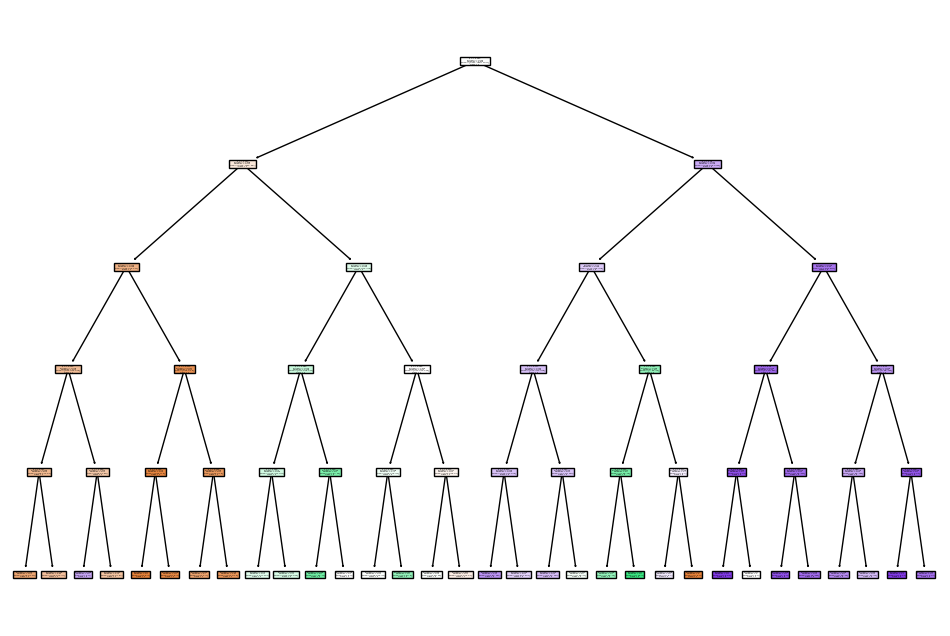

In [36]:
tree = DecisionTreeClassifier(criterion="entropy", max_depth=5)
tree.fit(train_logits[["1", "2", "3", "pred"]], train_logits["label"])

# Plot decision tree graph
plt.figure(figsize=(12, 8))
plot_tree(tree, feature_names=["1", "2", "3", "pred"], class_names=["1","2", "3"], filled=True)
plt.show()

In [37]:
train_preds = tree.predict(train_logits[["1", "2", "3", "pred"]])
train_accuracy = accuracy_score(train_logits["label"], train_preds)
print("Train Accuracy:", train_accuracy)

# Evaluate model on test set
test_preds = tree.predict(test_logits[["1", "2", "3", "pred"]])
test_accuracy = accuracy_score(test_logits["label"], test_preds)
print("Test Accuracy:", test_accuracy)

# Compute confusion matrix for test set
cm = confusion_matrix(test_logits["label"], test_preds)
print("Confusion Matrix:")
print(cm)

Train Accuracy: 0.5805555555555556
Test Accuracy: 0.5266666666666666
Confusion Matrix:
[[ 99  68  32]
 [ 40  66  74]
 [ 18  52 151]]


#### Decision Tree Could improve the generalization of the results on Testset by 4%

# 11. Regularization and More training

In [55]:
model.to("cpu").load_state_dict(torch.load("data_aug_last_model_checkpoint.pth")['model_state_dict'])

<All keys matched successfully>

In [56]:
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1, 1.5, 1], dtype=torch.float).to(device), label_smoothing=0.5)

In [57]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-3)

In [58]:
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, 100)

In [61]:
train_2 = training.Training(name="data_augReg", frozen_model=frozen_model, device=device)

In [62]:
train_2.frozen_model.train()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [63]:
train_2.complete_epoch(50, 
                       model.to(device), 
                       optimizer, 
                       scheduler, 
                       criterion, 
                       tokenizer, 
                       train_dataloader, 
                       test_dataloader
                      )

loss: 1.065197  [   32/ 5400]
loss: 1.022501  [ 3232/ 5400]
Epoch 1 has training_loss=1.0327026844024658, training_accuracy=0.5357407407407407
Epoch 1 has testing_loss=1.0755324363708496, testing_accuracy=0.43833333333333335
learning rate at epoch 0 = 9.997574711534357e-05
loss: 1.044440  [   32/ 5400]
loss: 1.062777  [ 3232/ 5400]
Epoch 2 has training_loss=1.0344425439834595, training_accuracy=0.5298148148148148
Epoch 2 has testing_loss=1.0779743194580078, testing_accuracy=0.445
loss: 1.012587  [   32/ 5400]
loss: 0.990324  [ 3232/ 5400]
Epoch 3 has training_loss=1.0339735746383667, training_accuracy=0.542962962962963
Epoch 3 has testing_loss=1.081121802330017, testing_accuracy=0.435
loss: 1.018674  [   32/ 5400]
loss: 1.061578  [ 3232/ 5400]
Epoch 4 has training_loss=1.0333949327468872, training_accuracy=0.5224074074074074
Epoch 4 has testing_loss=1.0782582759857178, testing_accuracy=0.43166666666666664
loss: 1.045960  [   32/ 5400]
loss: 1.037253  [ 3232/ 5400]
Epoch 5 has training_

loss: 1.110992  [ 3232/ 5400]
Epoch 38 has training_loss=1.0399760007858276, training_accuracy=0.49907407407407406
Epoch 38 has testing_loss=1.0673469305038452, testing_accuracy=0.455
loss: 1.085124  [   32/ 5400]
loss: 1.056902  [ 3232/ 5400]
Epoch 39 has training_loss=1.04102623462677, training_accuracy=0.5011111111111111
Epoch 39 has testing_loss=1.0674747228622437, testing_accuracy=0.4266666666666667
loss: 1.056908  [   32/ 5400]
loss: 1.059042  [ 3232/ 5400]
Epoch 40 has training_loss=1.04068922996521, training_accuracy=0.4761111111111111
Epoch 40 has testing_loss=1.0696746110916138, testing_accuracy=0.43166666666666664
loss: 1.057966  [   32/ 5400]
loss: 0.993924  [ 3232/ 5400]
Epoch 41 has training_loss=1.041023850440979, training_accuracy=0.4762962962962963
Epoch 41 has testing_loss=1.071826696395874, testing_accuracy=0.41833333333333333
learning rate at epoch 40 = 9.997327958494156e-05
loss: 1.096866  [   32/ 5400]
loss: 1.052668  [ 3232/ 5400]
Epoch 42 has training_loss=1.042

{'train': [tensor(1.0327, device='cuda:0'),
  tensor(1.0344, device='cuda:0'),
  tensor(1.0340, device='cuda:0'),
  tensor(1.0334, device='cuda:0'),
  tensor(1.0347, device='cuda:0'),
  tensor(1.0339, device='cuda:0'),
  tensor(1.0347, device='cuda:0'),
  tensor(1.0330, device='cuda:0'),
  tensor(1.0343, device='cuda:0'),
  tensor(1.0328, device='cuda:0'),
  tensor(1.0353, device='cuda:0'),
  tensor(1.0375, device='cuda:0'),
  tensor(1.0379, device='cuda:0'),
  tensor(1.0338, device='cuda:0'),
  tensor(1.0361, device='cuda:0'),
  tensor(1.0364, device='cuda:0'),
  tensor(1.0360, device='cuda:0'),
  tensor(1.0378, device='cuda:0'),
  tensor(1.0361, device='cuda:0'),
  tensor(1.0369, device='cuda:0'),
  tensor(1.0386, device='cuda:0'),
  tensor(1.0358, device='cuda:0'),
  tensor(1.0389, device='cuda:0'),
  tensor(1.0396, device='cuda:0'),
  tensor(1.0401, device='cuda:0'),
  tensor(1.0390, device='cuda:0'),
  tensor(1.0380, device='cuda:0'),
  tensor(1.0407, device='cuda:0'),
  tensor(1.

In [64]:
test_confusion_matrix = calc_confusion_matrix(model, 
                                         tokenizer, 
                                         testing_data, 
                                         device, 
                                         frozen_model
                                        )

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


In [65]:
test_confusion_matrix

{(3, 2): 200,
 (1, 2): 153,
 (1, 1): 43,
 (2, 2): 160,
 (3, 3): 16,
 (1, 3): 3,
 (2, 1): 14,
 (3, 1): 5,
 (2, 3): 6}

In [66]:
train_2.inference_from_path(model, 
                            tokenizer,
                            os.path.join(DATA_PATH, "test.csv"), 
                            "data_augReg_low_loss_model_checkpoint.pth", 
                            file_name="min_loss"
                           )

,ID,label
0,1,2
1,2,2
2,3,1
3,4,2
4,5,1
...,...,...
1796,1797,2
1797,1798,2
1798,1799,2
1799,1800,2


In [67]:
train_2.inference_from_path(model, 
                            tokenizer,
                            os.path.join(DATA_PATH, "test.csv"), 
                            "data_augReg_high_acc_model_checkpoint.pth",
                            file_name="max_acc"
                           )

,ID,label
0,1,3
1,2,2
2,3,1
3,4,2
4,5,2
...,...,...
1796,1797,1
1797,1798,2
1798,1799,2
1799,1800,2


# 12. Model defreezing

In [47]:
import training

In [48]:
class final_model(nn.Module):
    def __init__(self, frozen_model, model, checkpoint=None):
        super().__init__()
        self.frozen_model = frozen_model
        for param in self.frozen_model.parameters():
            param.requires_grad = True
        
        self.model = model
        if checkpoint:
            self.model.to("cpu").load_state_dict(torch.load(checkpoint)['model_state_dict'])

    def forward(self, x):
        pred = self.frozen_model(**x).logits
        pred = self.model(pred)
        return pred

In [49]:
final_model = final_model(frozen_model, model, "data_augReg_low_loss_model_checkpoint.pth")

In [50]:
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1, 1, 1], dtype=torch.float).to(device), label_smoothing=0.5)

In [52]:
import itertools

parameters_to_optimize = itertools.chain(
    final_model.frozen_model.roberta.encoder.parameters(),
    final_model.model.parameters()
)

optimizer = torch.optim.Adam(parameters_to_optimize, lr=1e-5, weight_decay=1e-4)


In [53]:
scheduler = lr_scheduler.LinearLR(optimizer)

In [54]:
train_3 = training.Training(name="whole_model", frozen_model=None, device=device, wrap_model=True)

TypeError: __init__() got an unexpected keyword argument 'wrap_model'

In [ ]:
train_3.complete_epoch(10, 
                       final_model.to(device), 
                       optimizer, 
                       scheduler, 
                       criterion, 
                       tokenizer, 
                       train_dataloader, 
                       test_dataloader
                      )

optimizer = torch.optim.Adam(final_model.parameters(), lr=1e-4, weight_decay=1e-2)

scheduler = lr_scheduler.CosineAnnealingLR(optimizer, 50)

train_3 = training.Training(name="whole_model", frozen_model=None, device=device, wrap_model=True)

train_3.complete_epoch(50, 
                       final_model.to(device), 
                       optimizer, 
                       scheduler, 
                       criterion, 
                       tokenizer, 
                       train_dataloader, 
                       test_dataloader
                      )

criterion = nn.CrossEntropyLoss(weight=torch.tensor([1, 2, 1], dtype=torch.float).to(device))

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=8e-4)

scheduler = lr_scheduler.CosineAnnealingLR(optimizer, 50)